# Machine Learning - Football 
(c) Felix Zeidler

** Goal: ** Predict game results via Machine Learning algorithms

Approach: use historic data from [Bundesliga.de](https://www.bundesliga.de)


In [16]:
# What system am I using
import sys
sys.version

'3.5.3 |Anaconda 4.4.0 (x86_64)| (default, Mar  6 2017, 12:15:08) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

## Set up analysis

### Import libraries

In [17]:
# Import libraries
import pickle
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Set options for this notebook
%matplotlib inline
sns.set_style(style="dark")
pd.set_option("display.max_columns",999)
#pd.set_option("display.max_rows",1000)

In [45]:
## sklearn imports 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, r2_score

### Load Data

In [40]:
filename = "Spieltagsdaten_Bundesliga_de_formatted.pickle"
pathtofile = os.path.join("Daten",filename)
with open(pathtofile, "rb") as handle:
    ligadaten = pickle.load(handle)

### Own functions used in this notebook

In [20]:
def transform_to_matches_features(ligadaten):
    '''Rearrange from 
    - team data (one row per team per game) to 
    - match data (one row per game)
    - features are calculated as the difference between HomeTeam and AwaysTeam'''
    
    columns = ligadaten.columns
    
    identifier_home = ligadaten.iloc[::2,1:14].reset_index(drop = True)
    identifier_away = ligadaten.iloc[1::2,6:14].reset_index(drop = True)
    identifier = identifier_home.merge(identifier_away, left_index=True,right_index=True,on = "spielausgang", suffixes=["_h","_a"])
    
    features = ligadaten.iloc[::2, 14::].reset_index(drop = True) - ligadaten.iloc[1::2,14::].reset_index(drop = True)
    
    matches = identifier.merge(features, left_index = True, right_index=True)
    
    return matches

In [21]:
def transform_to_matches(ligadaten):
    
    '''
    Rearrange from team data (one row per team per game) to match data (one row per game)
    
    ::input:: team data 
    ::output::
    - matchidentifier = teamnames, spieltag etc.
    - matchstats = torschüsse etc (indexed with "home" and "away")
    
    '''
    
    identifier_home = ligadaten.iloc[::2,1:14].reset_index(drop = True)
    identifier_away = ligadaten.iloc[1::2,6:14].reset_index(drop = True)
    matchidentifier = identifier_home.merge(identifier_away, left_index=True,right_index=True,on = "spielausgang", suffixes=["_h","_a"])
    
    home = ligadaten.iloc[::2,14:].reset_index()
    away = ligadaten.iloc[1::2,14:].reset_index()
    matchstats = pd.concat([home,away], axis = 1, join = "outer", keys = ["Home","Away"])
    matchstats = matchstats.drop('index',axis = 1,level = 1)

    return matchidentifier, matchstats
    

In [22]:
def select_features(X_train, y_train, kfeatures="all"):
    
    '''
    Goal: determine k best features to use for model
    Estimator: f_regression (see sklearn SelectKBest and f_regression) 
    
    :input: X, y, (both pandas) kfeatures (if nothing is specified all features are used)
    :output: pandas with column names and pvalues sorted for by smallest pvalue, i.e. first in list is best feature
    '''
    
    selector = SelectKBest(f_regression, k = kfeatures).fit(X_train, y_train)
    cols_selected = selector.get_support(indices = True)

    pvalues = selector.pvalues_[cols_selected]
    names = X_train.columns[cols_selected]
    
    features_pvalue_sort = pd.DataFrame(np.transpose([names,pvalues]), columns = ["columnNames", "pvalues"]).sort_values(by = ["pvalues"])
    
    return features_pvalue_sort

In [117]:
def transform_to_rollingavg(identifier, matchstats, rollwindow):
    
    
    '''
    Goal: for each team calculate for each game average stats of previous games. Separate for Home and Away (i.e. take e.g. 4 previous home stats if team is home team in specific game)
    
    
    :input: identifier, machtstats (original), rollwindow (e.g. 5 = average of previous 5 games)
    Note: identifier and matchstats are generated by running transform_to_matches() before
    
    :output: pandas with same shape as matchstats but with rolling averages
    '''
    
    ### Calculate rolling average of previous x HOME games for Home Teams
    games_home = pd.concat([identifier,matchstats["Home"]], axis = 1)
    games_home = games_home.sort_values(by = ["teamname_h","spielnr"]) #sortiere absteigend (zur Sicherheit - falls noch nciht sortiert)

    group_team = games_home.groupby(["saison","teamname_h"]) #group by saison and team
    cols_2calc = games_home.columns[20::] # define columns to calculate average on
    matchstats_rolling_avg = group_team[cols_2calc].rolling(window = rollwindow).mean() #calculate rolling average on group-object (groupbed by team)
    
    matchstats_rolling_avg = matchstats_rolling_avg.sort_index(level = 1).shift(1) #shift by 1 weil pro Spiel die Durchschnitte der vorangegangenen Spiele genommen werden sollen (exklusive des Spiels selber)
    matchstats_rolling_avg = matchstats_rolling_avg.reset_index()    
    
    values = matchstats_rolling_avg["saison"] # Array mit Saison 
    values_shifted = matchstats_rolling_avg["saison"].shift(1) # Array mit Saison eine Zeile später
    idx_nan = np.where(values != values_shifted, True, False) # Wenn != dann gibt es einen Saisonwechsel (2009 != 2010)
    matchstats_rolling_avg.loc[idx_nan, cols_2calc] = np.nan #erste Zeile muss nans erhalten, weil durch shift(1) bei rolling mean der erste Spieltag Werte aus der Vorsaison geshifted bekommen hat
    matchstats_rolling_avg = matchstats_rolling_avg.sort_values(by = "level_2", ascending = True)
    matchstats_rolling_avg.iloc[0,3:] = np.nan #aller erste Zeile des DFs erhält Nan (work around, weil hier vorher kein nan gesetzt. )
    matchstats_rolling_avg = matchstats_rolling_avg.set_index("level_2", drop = True)
    matchstats_rolling_avg_home = matchstats_rolling_avg[cols_2calc]   

    ### Calculate rolling average of previous x Away games for Away Teams
    games_away = pd.concat([identifier,matchstats["Away"]], axis = 1)
    games_away = games_away.sort_values(by = ["teamname_a","spielnr"]) #sortiere absteigend (zur Sicherheit - falls noch nciht sortiert)

    group_team = games_away.groupby(["saison","teamname_a"]) #group by saison and team
    cols_2calc = games_away.columns[20::] # define columns to calculate average on
    matchstats_rolling_avg = group_team[cols_2calc].rolling(window = rollwindow).mean() #calculate rolling average on group-object (groupbed by team)
    
    matchstats_rolling_avg = matchstats_rolling_avg.sort_index(level = 1).shift(1) #shift by 1 weil pro Spiel die Durchschnitte der vorangegangenen Spiele genommen werden sollen (exklusive des Spiels selber)
    matchstats_rolling_avg = matchstats_rolling_avg.reset_index()    
    
    values = matchstats_rolling_avg["saison"] # Array mit Saison 
    values_shifted = matchstats_rolling_avg["saison"].shift(1) # Array mit Saison eine Zeile später
    idx_nan = np.where(values != values_shifted, True, False) # Wenn != dann gibt es einen Saisonwechsel (2009 != 2010)
    matchstats_rolling_avg.loc[idx_nan, cols_2calc] = np.nan #erste Zeile muss nans erhalten, weil durch shift(1) bei rolling mean der erste Spieltag Werte aus der Vorsaison geshifted bekommen hat
    matchstats_rolling_avg = matchstats_rolling_avg.sort_values(by = "level_2", ascending = True)
    matchstats_rolling_avg.iloc[0,3:] = np.nan #aller erste Zeile des DFs erhält Nan (work around, weil hier vorher kein nan gesetzt. )
    matchstats_rolling_avg = matchstats_rolling_avg.set_index("level_2", drop = True)
    matchstats_rolling_avg_away = matchstats_rolling_avg[cols_2calc]

    ## Concatenate Home and Away DFs
    matchstats_rolling_avg = pd.concat([matchstats_rolling_avg_home,matchstats_rolling_avg_away], axis = 1, keys = ["Home","Away"])
    
    return matchstats_rolling_avg.reset_index(drop = True)

## 4 Models

In [234]:
matchstats["Home"].columns

Index(['shotstotal', 'shotsongoaltotal', 'shotstotaloutsidebox',
       'shotstotalinsidebox', 'shotsfootoutsidebox', 'shotsfootinsidebox',
       'shotstotalheader', 'chancenverwertung', 'chancen_inside',
       'passescompletedpercent', 'passesfailedpercent', 'passescompleted',
       'passesfailed', 'cornerkicks', 'cornerkicksleft', 'cornerkicksright',
       'crosses', 'crossesleft', 'crossesright', 'fastruns', 'intensiveruns',
       'fastrunsdistance', 'intensiverunsdistance', 'averagespeed', 'speed',
       'distance', 'sprints', 'sprintsdistance', 'yellowcards', 'redcards',
       'yellowredcards', 'offsides', 'foulscommitted', 'ballstouchedpercent',
       'ballstouched', 'handballs', 'duelswonpercent', 'duelswon',
       'activeplayercount', 'saison_platz', 'saison_punkte', 'saison_tordiff',
       'saison_tore', 'saison_gegentore'],
      dtype='object')

In [235]:
### Define input variables
dependent = "spielausgang"
test_size = 0.3
random_state = 9
preselect = False # Note: if True then model estimates best features
cols_selected = ["shotstotal", "shotsongoaltotal","chancenverwertung","ballstouched","duelswonpercent","saison_punkte", "saison_gegentore"]
pvalue_lbound =0.0001
scale_feature = True

In [239]:
### Transform from Team to Match

identifier, matchstats = transform_to_matches(ligadaten)
matchstats = transform_to_rollingavg(identifier, matchstats,5) ### Use Rolling Averages (i.e. approximations instead of real values (which are not available beforehand))

### Define X and y
dependent = dependent
feature_cols = matchstats["Home"].columns
X = matchstats["Home"][feature_cols] - matchstats["Away"][feature_cols]
y = identifier[dependent]

### Exclude NaNs
rows_notnans = X.notnull().all(axis = 1)
X, y, identifier, matchstats = X[rows_notnans], y[rows_notnans], identifier[rows_notnans],matchstats[rows_notnans]


### Split in train and test samples
test_size = test_size
random_state = random_state
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state = random_state)

### Save index of Train and Test sample for later use (e.g. for matchstats etc.)
idx_train, idx_test = X_train.index, X_test.index

### Select best X features
if preselect:
    num_features = num_features
    feature_list = select_features(X_train, y_train)
    feature_list = feature_list[feature_list["pvalues"] < pvalue_lbound]
    cols_selected = list(feature_list["columnNames"])

    
X_train, X_test = X_train.loc[:,cols_selected], X_test.loc[:, cols_selected]
X_train.shape, X_test.shape
cols_selected, X_train.shape, X_test.shape

(['shotstotal',
  'shotsongoaltotal',
  'chancenverwertung',
  'ballstouched',
  'duelswonpercent',
  'saison_punkte',
  'saison_gegentore'],
 (854, 7),
 (366, 7))

In [240]:
if scale_feature:
    X_train_scaled = preprocessing.scale(X_train)
    X_test_scaled = preprocessing.scale(X_test)
else:
    X_train_scaled = X_train
    X_test_scaled = X_test

In [243]:
### Predict Model: Linear Regression
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(X_train_scaled, y_train)
y_pred_lreg = regr.predict(X_test_scaled)
y_pred_lreg_rounded = [round(el) for el in y_pred_lreg]
accscore_lreg = (y_pred_lreg_rounded == y_test).sum() / len(y_test)

print("R2 of: ",r2_score(y_test,y_pred_lreg),"\nAccuracy Score of ", accscore_lreg)

R2 of:  -0.00368518371518 
Accuracy Score of  0.426229508197


In [244]:
### Predict Model: Bayes
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
y_pred_gaus = gnb.predict(X_test_scaled)
accscore_gaus = accuracy_score(y_test,y_pred_gaus, normalize=True)
print("Accuracy Score of: ",accscore_gaus)

Accuracy Score of:  0.44262295082


In [245]:
### Predict Model: SVM
clf = svm.LinearSVC(C = 0.5)
clf.fit(X_train_scaled, y_train)
y_pred_svm = clf.predict(X_test_scaled)
accscore_svm = accuracy_score(y_test,y_pred_svm, normalize=True)
print("Accuracy Score of: ",accscore_svm)

Accuracy Score of:  0.46174863388


In [246]:
### Predict Model: SVM
clf = svm.SVR(C = 1)
clf.fit(X_train_scaled, y_train)
y_pred_svr = clf.predict(X_test_scaled)

y_pred_svr_rounded = [round(el) for el in y_pred_svr]
accscore_svr = (y_pred_svr_rounded == y_test).sum() / len(y_test)
print("R2 of: ",r2_score(y_test,y_pred_svr),"\nAccuracy Score of ", accscore_svr)

R2 of:  -0.0409549992911 
Accuracy Score of  0.453551912568


In [247]:
matches_predicted = identifier.loc[idx_test,:]
matches_predicted["LinReg"] = np.where((y_pred_lreg_rounded - matches_predicted[dependent].astype(int)) == 0, True,False)
matches_predicted["Gauss"] = np.where((y_pred_gaus- matches_predicted[dependent].astype(int)) == 0, True,False)
matches_predicted["SVM"] = np.where((y_pred_svm- matches_predicted[dependent].astype(int)) == 0, True,False)
matches_predicted["SVR"] =  np.where((y_pred_svr_rounded- matches_predicted[dependent].astype(int)) == 0, True,False)

In [248]:
dist_pred = matches_predicted.groupby(dependent)["LinReg","Gauss","SVM","SVR"].sum()
dist_test = matches_predicted[dependent].value_counts().sort_index() 

In [249]:

accscores = [accscore_lreg,accscore_gaus,accscore_svm, accscore_svr]

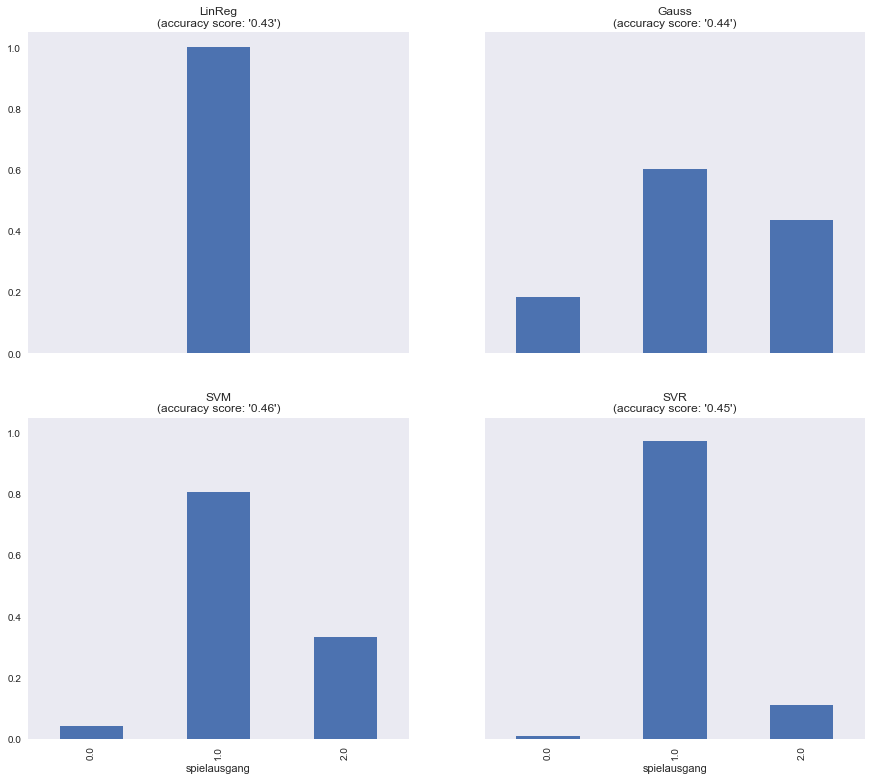

In [250]:
sns.set()
sns.set_style("dark")

fig, axes = plt.subplots(2,2,figsize = (15,13), sharex = True, sharey = True)
axes = [el for ax in axes for el in ax]
verteilungen = dist_pred.div(dist_test, axis = 0)
for i in range(0,len(verteilungen.columns)):
    ax = axes[i]
    verteilungen.iloc[:,i].plot(kind = "bar", ax = ax)
    ax.set_title(verteilungen.columns[i] + "\n(accuracy score: %r)"%("{:.2f}".format(accscores[i],2)))

In [297]:
p_test = dist_test  / dist_test.sum()
p_test

0.0    0.254098
1.0    0.426230
2.0    0.319672
Name: spielausgang, dtype: float64

In [298]:
accscore_simulated = []
for i in range(0,400):
    accscore_simulated.append((y_test == np.random.choice(p_test.index,size=(len(y_test)), p=p_test)).sum() / len(y_test))

In [299]:
np.mean(accscore_simulated)

0.34779371584699459

In [330]:
selected = 4
model = ["LinReg","Gauss","SVM","SVR"]
predicted = [y_pred_lreg_rounded,y_pred_gaus, y_pred_svm, y_pred_svr_rounded]
df = pd.DataFrame(predicted[selected-1], columns = ["yhat"])
df_guessed = df["yhat"].value_counts().sort_index()
df_right = dist_pred[model[selected-1]]
result = pd.concat([df_right, df_guessed], axis = 1)
result["correct"] = result.iloc[:,0] / result.iloc[:,1]
result["n"] = dist_test
result["real dist"] = dist_test / dist_test.sum()
result["yhat/n"] = result["yhat"] / result["n"].sum()
idx = result.isnull() == True
result[idx] = 0
result.columns = [model[selected-1]+" correct","predicted","correct/predicted","num real","real dist","predicted/real total"]
result

,SVR correct,predicted,correct/predicted,num real,real dist,predicted/real total
spielausgang,,,,,,
0.0,1.0,5,0.200000,93,0.254098,0.013661
1.0,152.0,344,0.441860,156,0.426230,0.939891
2.0,13.0,17,0.764706,117,0.319672,0.046448


In [961]:
np.random.randint(0,10000,size=(100,len(y_test))).shape

(100, 913)

array([[5, 6, 6, ..., 6, 2, 6],
       [4, 6, 5, ..., 1, 2, 5],
       [4, 4, 1, ..., 5, 4, 5],
       ..., 
       [6, 5, 4, ..., 5, 4, 5],
       [5, 5, 5, ..., 1, 6, 5],
       [6, 1, 6, ..., 6, 5, 1]])






## MODEL 1: Predict Spielausgang

**Dependent variable (y):** "spielausgang" which can take values 1 (home win), 2 (away win), 0 (draw)

**Independent variables (X):** 
 - differences in features (e.g. total shots) between home and away team
 - approach: feature selection via f score (scikit learn) 
 
**Model:** "Gaussian Bayes"

** Data :** one match per line

### Step 1: Rearrange data sample and define X and y

In [313]:
# transform data to one game per line (vs. 2 lines per game (home and away) in original dataset)
identifier, matchstats = transform_to_matches(ligadaten)

# define X, y and match_summary (Teamnames, game number, season, coaches etc.)
feature_cols = matchstats["Home"].columns
dependent = "spielausgang"
X = matchstats["Home"][feature_cols] - matchstats["Away"][feature_cols]
y = identifier[dependent]
X.shape, y.shape

((2448, 44), (2448,))

In [463]:
# use only subset of features in model
features_used = ["shotsongoaltotal", "chancenverwertung","chancen_inside","passescompletedpercent","cornerkicks","crosses","fastruns","intensiveruns","speed","sprints","ballstouchedpercent","duelswonpercent","saison_punkte"]
X_new = X.loc[:,features_used]
X_new.shape

(2448, 14)

### Step 2: deal with missing data

In [464]:
# find rows that do not contain nan, none or zero
idx = (X_new.isnull().any(axis = 1)) == False 
X,y,match_summary = X_new.loc[idx],y.loc[idx],match_summary.loc[idx]
X.shape,y.shape,match_summary.shape

((2140, 14), (2140,), (2140, 20))

In [465]:
## Exclude Bayern
exclude_team = False
if exclude_team:
    teamnames = match_summary["teamname_h"].astype(str) + match_summary["teamname_a"].astype(str)
    idx = teamnames.apply(lambda x: False if "FC Bayern München" in x else True)
    X, y, match_summary = X.loc[idx],y.loc[idx],match_summary.loc[idx]
    X.shape, y.shape, match_summary.shape

X.shape, y.shape, match_summary.shape

((2140, 14), (2140,), (2140, 20))

### Step 3: Set up Train and Test Split

In [466]:
from sklearn.model_selection import train_test_split
test_size = 0.6
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y, test_size = test_size)

# make same subsamples for match_summary (use indexes of train / test split)
match_summary_train, match_summary_test = match_summary.loc[Xtrain.index], match_summary.loc[Xtest.index]
ytest.shape

(1284,)

### Step 4: Fit and Predict model

In [467]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
y_pred = gnb.predict(Xtest)
print("Accuracy Score of: ",accuracy_score(ytest,y_pred, normalize=True))

Accuracy Score of:  0.759345794393


In [468]:
y_pred = pd.DataFrame(y_pred, index = Xtest.index, columns = ["y_pred"])
compare = pd.concat([match_summary_test,y_pred], axis = 1)
compare.head(1)

,saison,spiel,spieltag,spielnr,datum,ort_h,teamname_h,coach_h,tore_h,tordiff_h,punkte_h,spielausgang,ausgangstyp_h,ort_a,teamname_a,coach_a,tore_a,tordiff_a,punkte_a,ausgangstyp_a,y_pred
2066,2015,6.0,26.0,2067.0,2016-03-12 15:30:00,Home,Hannover 96,Thomas Schaaf,0.0,-2.0,0,2.0,Heimniederlage,Away,1.FC Köln,Peter Stöger,2.0,2.0,3,Auswärtssieg,2.0


### Step 5: Generalize Model for prediction
- independent variables for game x are not available beforehand
- independent variables need to be approximated

**Approach:** use average of previous n games to approximate independent variables 


In [469]:
## Define approximation approach:
metric = "mean"
periods = 5

## Define match to predict
saison = 2016
spieltag = 20
match_to_predict = match_summary.loc[(match_summary.saison == saison) & (match_summary.spieltag == spieltag)]
#match_to_predict

In [470]:
data_hometeams = pd.DataFrame()
hometeams = match_to_predict["teamname_h"].unique()
for hometeamname in hometeams: 

    idx = ligadaten.loc[(ligadaten.saison == saison) & (ligadaten.spieltag == spieltag) &(ligadaten.teamname == hometeamname)].index[0]
    hometeam_data = ligadaten.loc[(ligadaten["ort"] == "Home") & (ligadaten["teamname"] == hometeamname) &(ligadaten.index < idx)].tail(periods)

    if metric == "mean":
        hometeam_average = hometeam_data.loc[:,features_used].mean()
    if metric == "median":
        hometeam_average =  hometeam_data.loc[:,features_used].median()
    data_hometeams = pd.concat([data_hometeams, hometeam_average], axis = 1)
data_hometeams = data_hometeams.T

In [471]:
data_awayteams = pd.DataFrame()
awayteams = match_to_predict["teamname_a"].unique()
for awayteamname in awayteams: 

    idx = ligadaten.loc[(ligadaten.saison == saison) & (ligadaten.spieltag == spieltag) &(ligadaten.teamname == awayteamname)].index[0]
    awayteam_data = ligadaten.loc[(ligadaten["ort"] == "Away") & (ligadaten["teamname"] == awayteamname) &(ligadaten.index < idx)].tail(periods)

    if metric == "mean":
        awayteam_average = awayteam_data.loc[:,features_used].mean()
    if metric == "median":
        awayteam_average =  awayteam_data.loc[:,features_used].median()
    data_awayteams = pd.concat([data_awayteams, awayteam_average], axis = 1)
data_awayteams = data_awayteams.T

In [472]:
X_features = data_hometeams - data_awayteams
y_predict = gnb.predict(X_features)
y_predict, accuracy_score(match_to_predict.spielausgang, y_predict)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 0.0)

In [473]:
match_to_predict["spielausgang_predict"] = y_predict
match_to_predict["Correct"] = np.where(match_to_predict["spielausgang"] == match_to_predict["spielausgang_predict"],True,False)

/Users/Felix/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Felix/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [474]:
match_to_predict#.groupby("spielausgang")["Correct"].sum()

,saison,spiel,spieltag,spielnr,datum,ort_h,teamname_h,coach_h,tore_h,tordiff_h,punkte_h,spielausgang,ausgangstyp_h,ort_a,teamname_a,coach_a,tore_a,tordiff_a,punkte_a,ausgangstyp_a,spielausgang_predict,Correct
2313,2016,1.0,20.0,2314.0,2017-02-10 20:30:00,Home,1.FSV Mainz 05,Martin Schmidt,2.0,2.0,3,1.0,Heimsieg,Away,FC Augsburg,Manuel Baum,0.0,-2.0,0,Auswärtsniederlage,0.0,False
2314,2016,2.0,20.0,2315.0,2017-02-11 15:30:00,Home,FC Ingolstadt 04,Maik Walpurgis,0.0,-2.0,0,2.0,Heimniederlage,Away,FC Bayern München,Carlo Ancelotti,2.0,2.0,3,Auswärtssieg,0.0,False
2315,2016,3.0,20.0,2316.0,2017-02-11 15:30:00,Home,Bayer 04 Leverkusen,Roger Schmidt,3.0,3.0,3,1.0,Heimsieg,Away,Eintracht Frankfurt,Niko Kovac,0.0,-3.0,0,Auswärtsniederlage,0.0,False
2316,2016,4.0,20.0,2317.0,2017-02-11 15:30:00,Home,SV Darmstadt 98,Torsten Frings,2.0,1.0,3,1.0,Heimsieg,Away,Borussia Dortmund,Thomas Tuchel,1.0,-1.0,0,Auswärtsniederlage,0.0,False
2317,2016,5.0,20.0,2318.0,2017-02-11 15:30:00,Home,Werder Bremen,Alexander Nouri,0.0,-1.0,0,2.0,Heimniederlage,Away,Borussia M'gladbach,Dieter Hecking,1.0,1.0,3,Auswärtssieg,0.0,False
2318,2016,6.0,20.0,2319.0,2017-02-11 15:30:00,Home,RB Leipzig,Ralph Hasenhüttl,0.0,-3.0,0,2.0,Heimniederlage,Away,Hamburger SV,Markus Gisdol,3.0,3.0,3,Auswärtssieg,0.0,False
2319,2016,7.0,20.0,2320.0,2017-02-11 18:30:00,Home,FC Schalke 04,Markus Weinzierl,2.0,2.0,3,1.0,Heimsieg,Away,Hertha BSC,Pal Dardai,0.0,-2.0,0,Auswärtsniederlage,0.0,False
2320,2016,8.0,20.0,2321.0,2017-02-12 15:30:00,Home,VfL Wolfsburg,Valerien Ismael,2.0,1.0,3,1.0,Heimsieg,Away,1899 Hoffenheim,Julian Nagelsmann,1.0,-1.0,0,Auswärtsniederlage,0.0,False
2321,2016,9.0,20.0,2322.0,2017-02-12 17:30:00,Home,SC Freiburg,Christian Streich,2.0,1.0,3,1.0,Heimsieg,Away,1.FC Köln,Peter Stöger,1.0,-1.0,0,Auswärtsniederlage,0.0,False


# Simuliere Accuracy Score for one Season

In [475]:
## Define match to predict
saisons = [2016]
spieltage = np.arange(periods +1,35,1)
scores = []
for saison in saisons:
    for spieltag in spieltage:
        #print(saison, spieltag)
        
        ## Define Spieltag (d.h. Spiele, die vorhergesagt werden sollen)
        match_to_predict = match_summary.loc[(match_summary.saison == saison) & (match_summary.spieltag == spieltag)]
        
        ## Errechne Durchschnittsfeatuers für Heimteams
        data_hometeams = pd.DataFrame()
        hometeams = match_to_predict["teamname_h"].unique()
        for hometeamname in hometeams: 

            idx = ligadaten.loc[(ligadaten.saison == saison) & (ligadaten.spieltag == spieltag) &(ligadaten.teamname == hometeamname)].index[0]
            hometeam_data = ligadaten.loc[(ligadaten["ort"] == "Home") & (ligadaten["teamname"] == hometeamname) &(ligadaten.index < idx)].tail(periods)

            if metric == "mean":
                hometeam_average = hometeam_data.loc[:,features_used].mean()
            if metric == "median":
                hometeam_average =  hometeam_data.loc[:,features_used].median()
            data_hometeams = pd.concat([data_hometeams, hometeam_average], axis = 1)
        data_hometeams = data_hometeams.T
        
        ## Errechne Durchschnittsfeatuers für Auswärtsteams
        data_awayteams = pd.DataFrame()
        awayteams = match_to_predict["teamname_a"].unique()
        for awayteamname in awayteams: 

            idx = ligadaten.loc[(ligadaten.saison == saison) & (ligadaten.spieltag == spieltag) &(ligadaten.teamname == awayteamname)].index[0]
            awayteam_data = ligadaten.loc[(ligadaten["ort"] == "Away") & (ligadaten["teamname"] == awayteamname) &(ligadaten.index < idx)].tail(periods)

            if metric == "mean":
                awayteam_average = awayteam_data.loc[:,features_used].mean()
            if metric == "median":
                awayteam_average =  awayteam_data.loc[:,features_used].median()
            data_awayteams = pd.concat([data_awayteams, awayteam_average], axis = 1)
        data_awayteams = data_awayteams.T
        
        
        X_features = data_hometeams - data_awayteams
        y_predict = gnb.predict(X_features)
        score = accuracy_score(match_to_predict.spielausgang, y_predict)
        scores.append([saison, spieltag,score])


'0.30'

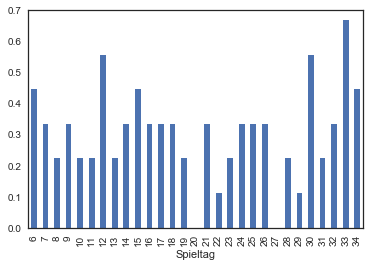

In [476]:
df = pd.DataFrame(scores, columns = ["Saison","Spieltag","Score"])
df.groupby("Spieltag")["Score"].mean().plot(kind = "bar")
"{:.2f}".format(np.array(scores)[:,2].mean())

In [477]:
### Simulate Zufallsmodell:
verteilung = round(ligadaten.loc[(ligadaten["saison"] >= saisons[0]) & (ligadaten["spieltag"] >=6)]["spielausgang"].value_counts() / ligadaten.loc[(ligadaten["saison"] >= saisons[0])]["spielausgang"].count() * 1000)
verteilung = [int(el) for el in list(verteilung.sort_index())]
verteilung

[209, 415, 229]

In [478]:
container = [0] * verteilung[0] + [1] * verteilung[1] + [2] * verteilung[2]
len(container)

853

In [334]:
zufall = np.reshape([container[el] for liste in np.random.randint(0,853,size=(1000,9)) for el in liste],(1000,9))
(zufall == y_predict).sum(axis = 1).mean() / 9

0.40655555555555556

In [335]:
y_predict = [1,1,1,2,1,0,1,1,0]

In [336]:
(zufall == y_predict).sum(axis = 1).mean() / 9

0.40655555555555556

In [321]:
zufall = np.random.randint(0,1000,(10000,9))
zufall

(10000, 9)

In [270]:
ligadaten.spielausgang.value_counts() / ligadaten.spielausgang.count()

1.0    0.453431
2.0    0.302696
0.0    0.243873
Name: spielausgang, dtype: float64

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lreg = LinearRegression(fit_intercept=True, normalize = True)
y_pred = lreg.fit(Xtrain,ytrain).predict(Xtest)
y_pred = pd.DataFrame(y_pred, index = Xtest.index, columns = ["y_pred"])
compare = pd.concat([match_summary_test,y_pred], axis = 1)

print("R2 score of: ", r2_score(ytest,y_pred))

R2 score of:  0.822340658099


In [120]:
idx = (compare[dependent] != compare.y_pred.apply(lambda x: round(x)))
len(compare.loc[idx]) / len(ytest)

0.4680685358255452

In [110]:
y_pred["y_pred_rounded"] = y_pred.apply(lambda x: round(x))

In [111]:
y_pred

,y_pred,y_pred_rounded
161,-0.274168,-0.0
704,2.630849,3.0
1952,1.534158,2.0
1803,0.849043,1.0
1894,-3.055494,-3.0
707,1.454525,1.0
1053,1.648196,2.0
810,-0.389578,-0.0
683,-1.004544,-1.0
555,0.364918,0.0


## Model: Predict Spielausgang (1=Heimsieg, 2=Auswärtssieg, 0=Unentschieden

### (0) Rearrage data sample
i.e. 1 line per game  

In [512]:
home = home.loc[:,home.columns[14::]].reset_index(drop = True)
away = away.loc[:,away.columns[14::]].reset_index(drop = True)
delta = home - away
delta.shape

(2448, 44)

### (1) All: Define X and y (i.e. features to use in model and dependent variable)

In [513]:
y = data.spielausgang_h.reset_index(drop= True)

model_data = pd.concat([y, delta], axis = 1)
model_data.head()

model_data.shape

(2448, 45)

### (1) Subset: Define X and y (i.e. features to use in model and dependent variable)

In [473]:
delta_chancenverwertung = data.chancenverwertung_h - data.chancenverwertung_a
delta_chancen_inside = data.chancen_inside_h - data.chancen_inside_a
delta_torschüsse = data.shotstotal_h - data.shotstotal_a
delta_passquote = data.passescompletedpercent_h - data.passescompletedpercent_a
delta_ballbesitz = data.ballstouchedpercent_h - data.ballstouchedpercent_a

y = data.spielausgang_h

model_data = pd.concat([y, delta_chancen_inside, delta_torschüsse, delta_passquote,delta_ballbesitz,delta_chancenverwertung, ], axis = 1)
model_data.columns = ["Spielausgang_y","ChancenInside_x","Torschüsse_x","Passquote_x","Ballbesitz_x","Chancenverwertung_x",]
model_data.head()

,Spielausgang_y,ChancenInside_x,Torschüsse_x,Passquote_x,Ballbesitz_x,Chancenverwertung_x
0,1.0,0.171429,-1.0,-2.77,-3.22,0.142857
1,1.0,0.259740,15.0,-0.88,10.30,0.045455
2,2.0,0.200000,5.0,8.35,16.08,-0.133333
3,1.0,0.333333,-5.0,0.88,-1.66,0.100000
4,0.0,-0.581197,-4.0,-0.56,-3.04,0.068376


- exclude data with NaNs (scikit models have trouble dealing with this input)
- rename to X and y**

In [514]:
model_data = model_data.dropna(axis = 0, how = "any")
X = model_data.loc[:,model_data.columns[1::]]
y = model_data.loc[:,columns[0]]
X.shape

(1826, 44)

### (2a) Optional: reduce dimensions / select best features

In [515]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
k = 10
print("F-Scores: ",SelectKBest(f_classif, k=k).fit(X,y).scores_)
X_reduced = SelectKBest(f_classif, k=k).fit_transform(X,y)

F-Scores:  [  6.67822135e+01   3.21507878e+02   1.98248722e+00   1.23519698e+02
   1.82849457e+00   1.91703000e+02   2.00711952e+00   1.08634057e+03
   6.43733265e+01   7.09028552e+00   7.09036343e+00   7.86079331e+00
   4.77384165e+01   1.56436374e+00   1.00124165e+00   9.58091851e-01
   2.02773778e+01   1.11404903e+01   1.78891858e+01   7.74763652e+00
   5.54606684e-01   1.05546690e+01   9.63773209e-01   1.04534994e+02
   1.00784945e+02   3.27841298e+01   1.54603711e+01   3.54685210e+01
   2.00565550e+01   1.72889416e+01   1.19918077e+01   2.09913741e+00
   3.29363714e+00   4.50236224e+00   6.32718764e+00   8.30749782e-02
   3.91865351e+01   3.71051623e+01   2.61037177e+01   3.18002775e+02
   2.25961222e+02   1.95495694e+02   1.54668457e+02   1.35299491e+02]


In [540]:
fit = SelectKBest(f_classif, k=k).fit(X,y)
[(i,el) for i,el in  zip(X.columns,fit.scores_)]

[('shotstotal', 66.782213549088269),
 ('shotsongoaltotal', 321.50787815564701),
 ('shotstotaloutsidebox', 1.982487219349788),
 ('shotstotalinsidebox', 123.5196981862081),
 ('shotsfootoutsidebox', 1.8284945738402971),
 ('shotsfootinsidebox', 191.7030004030413),
 ('shotstotalheader', 2.0071195224627529),
 ('chancenverwertung', 1086.340565813824),
 ('chancen_inside', 64.373326502571501),
 ('passescompletedpercent', 7.0902855164580325),
 ('passesfailedpercent', 7.0903634340149626),
 ('passescompleted', 7.860793313897303),
 ('passesfailed', 47.738416474282623),
 ('cornerkicks', 1.5643637444423488),
 ('cornerkicksleft', 1.0012416474033197),
 ('cornerkicksright', 0.95809185065181091),
 ('crosses', 20.277377802613817),
 ('crossesleft', 11.140490328515034),
 ('crossesright', 17.889185763945846),
 ('fastruns', 7.7476365194260612),
 ('intensiveruns', 0.55460668432048399),
 ('fastrunsdistance', 10.554668955089264),
 ('intensiverunsdistance', 0.96377320858134363),
 ('averagespeed', 104.534994412204

In [545]:
import statsmodels.api as sm
from scipy import stats


X2 = sm.add_constant(X)

In [549]:
est = sm.OLS(y, X2.loc[:,X2.columns[0:4]])
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         spielausgang_h   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     48.84
Date:                Wed, 30 Aug 2017   Prob (F-statistic):           2.35e-30
Time:                        15:46:35   Log-Likelihood:                -1972.2
No. Observations:                1826   AIC:                             3952.
Df Residuals:                    1822   BIC:                             3974.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0817      0.018     61.426      0.000       1.047       1.116
shotstotal               0.0038      0.004      0.927      0.354      -0.004       0.012
shotsongoaltotal        -0.0619      0.006     -9.530      0.000      -0.075      -0.049
shotstotaloutsidebox     0.0097      0.006      1.560      0.119      -0.002       0.022
==============================================================================
Omnibus:                      431.510   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.129
Skew:                          -0.389   Prob(JB):                     4.98e-27
Kurtosis:                       2.007   Cond. No.                         10.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### (2) Split data in train and test samples

In [481]:
from sklearn.model_selection import train_test_split
train_size = 0.75 # % of total sample
Xtrain, Xtest, ytrain, ytest = train_test_split(X_reduced, y,train_size =train_size, random_state = 1)
Xtrain.shape, Xtest.shape

((1369, 10), (457, 10))

### (3) Create and test prediction model

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(Xtrain, ytrain).predict(Xtest)


from sklearn.metrics import accuracy_score
print("Accuracy Score of: ",accuracy_score(ytest,y_pred, normalize=True))

### (4) Compare results

In [484]:
idx = Xtest.index
y_pred_df = pd.DataFrame(y_pred,index = idx, columns = ["Spielausgang_Vorhersage"])
test_df = data.loc[idx]
result_compare =pd.concat([y_pred_df,test_df], axis = 1)
#result_compare.loc[result_compare.Spielausgang_Vorhersage != result_compare.spielausgang_h].ausgangstyp_h.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [178]:
1015/1223


0.8299264104660671

In [164]:
pd.concat([pd.DataFrame(y_pred),data.loc[idx]], axis = 1)

,0,titel,saison,spiel,spieltag,spielnr,datum,ort_h,teamname_h,coach_h,tore_h,tordiff_h,punkte_h,spielausgang_h,ausgangstyp_h,shotstotal_h,shotsongoaltotal_h,shotstotaloutsidebox_h,shotstotalinsidebox_h,shotsfootoutsidebox_h,shotsfootinsidebox_h,shotstotalheader_h,chancenverwertung_h,chancen_inside_h,passescompletedpercent_h,passesfailedpercent_h,passescompleted_h,passesfailed_h,cornerkicks_h,cornerkicksleft_h,cornerkicksleft_h,crosses_h,crossesleft_h,crossesright_h,fastruns_h,intensiveruns_h,fastrunsdistance_h,intensiverunsdistance_h,averagespeed_h,speed_h,distance_h,sprints_h,sprintsdistance_h,yellowcards_h,redcards_h,yellowredcards_h,offsides_h,foulscommitted_h,ballstouchedpercent_h,ballstouched_h,handballs_h,duelswonpercent_h,duelswon_h,activeplayercount_h,saison_platz_h,saison_punkte_h,saison_tordiff_h,saison_tore_h,saison_gegentore_h,ort_a,teamname_a,coach_a,tore_a,tordiff_a,punkte_a,spielausgang_a,ausgangstyp_a,shotstotal_a,shotsongoaltotal_a,shotstotaloutsidebox_a,shotstotalinsidebox_a,shotsfootoutsidebox_a,shotsfootinsidebox_a,shotstotalheader_a,chancenverwertung_a,chancen_inside_a,passescompletedpercent_a,passesfailedpercent_a,passescompleted_a,passesfailed_a,cornerkicks_a,cornerkicksleft_a,cornerkicksleft_a,crosses_a,crossesleft_a,crossesright_a,fastruns_a,intensiveruns_a,fastrunsdistance_a,intensiverunsdistance_a,averagespeed_a,speed_a,distance_a,sprints_a,sprintsdistance_a,yellowcards_a,redcards_a,yellowredcards_a,offsides_a,foulscommitted_a,ballstouchedpercent_a,ballstouched_a,handballs_a,duelswonpercent_a,duelswon_a,activeplayercount_a,saison_platz_a,saison_punkte_a,saison_tordiff_a,saison_tore_a,saison_gegentore_a
0,1.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,"1. SPIELTAG, 1.FSV MAINZ 05 : BAYER 04 LEVERKU...",2009.0,5.0,1.0,5.0,2009-08-08 15:30:00,Home,1.FSV Mainz 05,Thomas Tuchel,2.0,0.0,1.0,0.0,Unentschieden,9.0,4.0,8.0,1.0,8.0,0.0,1.0,0.222222,0.111111,76.36,23.64,294.0,91.0,3.0,1.0,1.0,4.0,2.0,2.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.0,0.0,4.0,22.0,48.48,606.0,2.0,52.61,111.0,0.0,8.0,1.0,0.0,2.0,2.0,Away,Bayer 04 Leverkusen,Jupp Heynckes,2.0,-0.0,1.0,0.0,Unentschieden,13.0,7.0,4.0,9.0,4.0,7.0,2.0,0.153846,0.692308,76.92,23.08,330.0,99.0,5.0,2.0,2.0,9.0,3.0,6.0,0.0,0.0,0.00,0.00,0.00,0.0

In [116]:
(ytest == y_pred).sum() / len(ytest)

0.82502044153720355

In [10]:
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
X.shape

X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
X_new.shape

NameError: name 'X' is not defined

In [ ]:
imp

In [11]:
delta_goodchance = df.shotstotalinsidebox_h / df.shotstotal_h - df.shotstotalinsidebox_a / df.shotstotal_a
delta_chancenverwertung = df.tore_h / df.shotstotal_h - df.tore_a / df.shotstotal_a
delta_ballbesitz = df.ballstouchedpercent_h - df.ballstouchedpercent_a
X = pd.concat([delta_chancenverwertung,delta_ballbesitz, delta_goodchance], axis = 1)
y = df.tordiff_h
len(X),len(y)

(2448, 2448)

In [12]:
idx =  X.notnull().all(axis = 1)
X = X.loc[idx,[0,1,2]]
y = y.loc[idx]

In [13]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,random_state=1)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression(fit_intercept=True)
model.fit(Xtrain,ytrain)
y_model = model.predict(Xtest)

In [15]:
r2_score(y_model,ytest)

0.54742723002966032

In [231]:
from sklearn.decomposition import PCA
model = PCA(n_components = 2)
model.f(X)
X_2D = model.transform(X)

In [232]:
X = pd.DataFrame()
X["PCA1"] = X_2D[:,0]
X["PCA2"] = X_2D[:,1]
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,random_state=1)

In [233]:
model = LinearRegression(fit_intercept=True)
model.fit(Xtrain,ytrain)
y_model = model.predict(Xtest)

In [235]:
model.coef_

array([-0.01890226,  3.3352409 ])

In [236]:
r2_score(y_model,ytest)

-2.9462908039757023

In [227]:
np.shape(y_model)

(612,)

In [238]:
X

,PCA1,PCA2
0,5.135375,0.186284
1,-8.384814,0.230877
2,-14.164919,0.116618
3,3.575139,0.327277
4,4.956199,-0.555395
5,-11.944558,-0.158138
6,6.495795,-0.293138
7,-7.184207,-0.565535
8,7.535590,-0.144902
9,-11.004030,-0.251784


In [228]:
np.shape(ytest)

(612,)

In [251]:
sns.lmplot(X.loc[:,0], X.loc[:,2], data = X, fit_reg=True)

KeyError: '[-0.73333333 -0.72727273 -0.71666667 ...,  0.77777778  0.875       0.88888889] not in index'

In [128]:
import pandas

date = ["25/12/2017","12/11/2014"]
injury = [30,534]
#datesinjured = pd.date_range(date, periods = injury, freq = "D")

ValueError: Periods must be a number, got [30, 534]

In [166]:
dateranges = [pd.date_range(datum,periods = injury, freq = "D") for datum, injury in zip(date,injury)]

In [167]:
df = pd.DataFrame({"Dates":["2017-01-01","2017-01-05","2017-01-07","2017-01-09"], "Inventory":[10,-5,15,-20]})

In [168]:
df.Dates = pd.to_datetime(df.Dates)
df = df.set_index("Dates")
df

,Inventory
Dates,
2017-01-01,10
2017-01-05,-5
2017-01-07,15
2017-01-09,-20


In [163]:
df = df.Inventory.cumsum().resample("D").pad()
df

Dates
2017-01-01    10
2017-01-02    10
2017-01-03    10
2017-01-04    10
2017-01-05     5
2017-01-06     5
2017-01-07    20
2017-01-08    20
2017-01-09     0
Freq: D, Name: Inventory, dtype: int64

In [170]:
df.where(df.Inventory != 10,19)

,Inventory
Dates,
2017-01-01,19
2017-01-05,-5
2017-01-07,15
2017-01-09,-20


In [173]:
df.where(df % 3 == 0,df.where())

,Inventory
Dates,
2017-01-01,-10
2017-01-05,5
2017-01-07,15
2017-01-09,20


## Event Study - Borussia Dortmund

In [31]:
from pandas_datareader import data, wb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot, scatter_matrix
plt.style.use("ggplot")

%matplotlib inline

In [20]:
stockdata = data.DataReader(["Googl","IBM"], data_source="google")["Close"]
stockdata.head()

,Googl,IBM
Date,,
2010-01-04,313.69,132.45
2010-01-05,312.31,130.85
2010-01-06,304.43,130.00
2010-01-07,297.35,129.55
2010-01-08,301.31,130.85


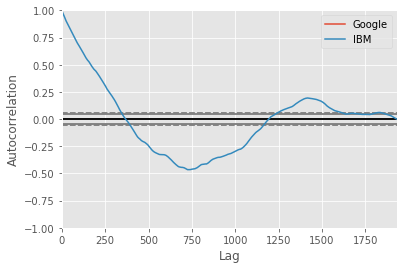

In [30]:
_ = autocorrelation_plot(stockdata["Googl"], label = "Google")
_ = autocorrelation_plot(stockdata["IBM"], label = "IBM")

In [22]:
log_return = pd.DataFrame()
log_return["Google"] = np.log(stockdata["Googl"] / stockdata["Googl"].shift())
log_return["IBM"] = np.log(stockdata["IBM"] / stockdata["IBM"].shift())

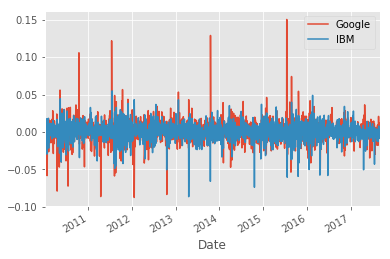

In [24]:
_ = log_return.plot()

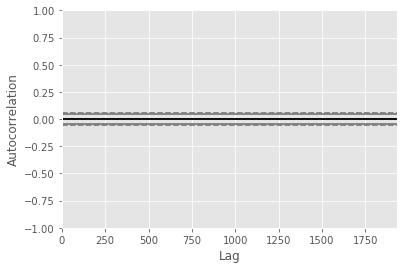

In [27]:
_ = autocorrelation_plot(log_return["Google"])
_ = autocorrelation_plot(log_return["IBM"])

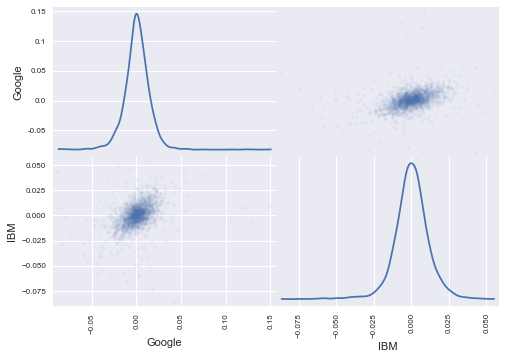

In [40]:
_ = scatter_matrix(log_return, grid=False,alpha=0.05,diagonal="density")

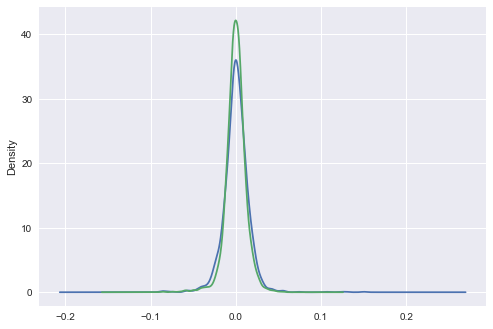

In [43]:
_ = log_return["Google"].plot(kind = "kde", label = "Google")
_ = log_return["IBM"].plot(kind = "kde")

In [51]:
log_return.corr().iloc[:,0]

Google    1.000000
IBM       0.394224
Name: Google, dtype: float64